In [1]:
import psycopg2
import pandas as pd
pd.options.display.max_columns = 999

In [6]:
user = 'read_user'
password = ''
ip = '192.168.1.106'
port = '5432'
dbname = 'chess_db'

In [11]:
db_connection_string = 'postgresql://{}:{}@{}:{}/{}'

with psycopg2.connect(db_connection_string.format(user,
                                                  password,
                                                  ip,
                                                  port,
                                                  dbname)) as con:
    cursor = con.cursor('chess_analysis')

    sql = """SELECT * from chess_games;"""
    cursor.execute(sql)
    colnames = [desc.name for desc in cursor.description]
    results = cursor.fetchall()

In [19]:
import sys
sys.getsizeof(cursor)

224

In [12]:
df = pd.DataFrame.from_records(results, columns=colnames)

In [13]:
df.head()

,id,event_type,result,round,game_link,termination,chess_variant,black_elo_tentative,white_elo_tentative,player,opponent,player_color,opponent_color,player_rating_diff,opponent_rating_diff,player_result,opponent_result,time_control_category,datetime_played,starting_time,increment,in_arena,rated_casual,player_elo,opponent_elo,queen_exchange,player_castling_side,opponent_castling_side,lichess_opening,opening_played
0,3,Rated Blitz game,1-0,-,https://lichess.org/ZhmhCY7m,Time forfeit,Standard,Unknown,Unknown,Grahtbo,moreman28,white,black,11.0,-11.0,Win,Loss,blitz,2019-07-25 15:22:54,180,0,Not in arena,Rated,1460.0,1495.0,Queen exchange,kingside,No castling,St. George Defense,B00
1,4,Rated Blitz game,0-1,-,https://lichess.org/7SX80GTy,Normal,Standard,Unknown,Unknown,Grahtbo,krarr,black,white,11.0,-11.0,Win,Loss,blitz,2019-07-25 15:08:41,180,0,Not in arena,Rated,1449.0,1462.0,No queen exchange,kingside,kingside,Hungarian Opening,A00
2,5,Rated Blitz game,1-0,-,https://lichess.org/bIyC1c5J,Normal,Standard,Unknown,Unknown,Grahtbo,cefh,white,black,10.0,-10.0,Win,Loss,blitz,2019-07-25 15:07:27,180,0,Not in arena,Rated,1439.0,1444.0,No queen exchange,No castling,No castling,Latvian Gambit,C40
3,6,Rated Blitz game,1/2-1/2,-,https://lichess.org/cZXuLZ0B,Normal,Standard,Unknown,Unknown,Grahtbo,krds,white,black,0.0,0.0,Draw,Draw,blitz,2019-07-25 14:59:00,300,0,Not in arena,Rated,1439.0,1442.0,Queen exchange,queenside,No castling,Four Knights Game,C46
4,7,Rated Blitz game,0-1,-,https://lichess.org/oRuOpiWj,Normal,Standard,Unknown,Unknown,Grahtbo,hugotrasher77-7,black,white,9.0,-9.0,Win,Loss,blitz,2019-07-25 14:51:48,180,0,Not in arena,Rated,1430.0,1405.0,No queen exchange,kingside,kingside,"Latvian Gambit Accepted, Foltys Variation",C40


In [14]:
df.shape

(13249, 30)

In [122]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion='entropy', random_state=0, min_samples_leaf=10, min_samples_split=30, max_depth=5)

In [123]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for col in df.columns:
    df[col] = le.fit_transform(df[col])

In [124]:
trim_df = df.drop(['result',
                   'player_rating_diff',
                   'opponent_rating_diff',
                   'opponent_result',
                   'game_link',
                   'id',
                   ],
                  axis=1)

In [125]:
trim_df['rating_diff'] = trim_df['player_elo'] - trim_df['opponent_elo']

In [126]:
test_df = trim_df.sample(frac=0.2, random_state=0)
train_df = trim_df.drop(test_df.index)

In [127]:
dtc.fit(train_df.drop('player_result', axis=1), train_df['player_result'])
dtc.score(train_df.drop('player_result', axis=1), train_df['player_result'])

0.5627889423530522

In [128]:
dtc.score(test_df.drop('player_result', axis=1), test_df['player_result'])

0.5566037735849056

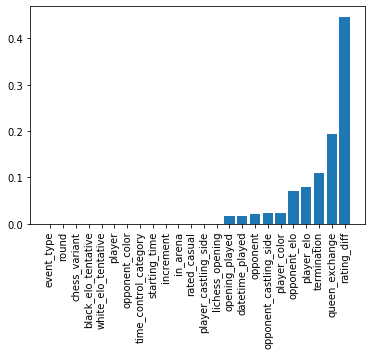

In [129]:
import matplotlib.pyplot as plt
%matplotlib inline

feature_importances = [x for x in zip(train_df.drop('player_result', axis=1).columns,
                                      dtc.feature_importances_)]
feature_importances.sort(key=lambda x: x[1])
plt.bar(*zip(*feature_importances))
plt.xticks(rotation='vertical')
plt.show()

In [145]:
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint as sp_randint

results = {}

rfc = RandomForestClassifier(random_state=0, n_jobs=1)

param_distributions = {'criterion': ['gini',
                                     'entropy',
                                    ],
                       'min_samples_split': sp_randint(10, 150),
                       'max_depth': sp_randint(2, 50),
                       'n_estimators': sp_randint(10, 200),
                       'min_samples_leaf': sp_randint(1, 300),
                      }

rcv = RandomizedSearchCV(estimator=rfc,
                         param_distributions=param_distributions,
                         n_jobs=10,
                         cv=10,
                         n_iter=200,
                         random_state=0)

In [146]:
rcv.fit(train_df.drop('player_result', axis=1), train_df['player_result'])

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=1, 

In [147]:
best_rfc = rcv.best_estimator_

In [148]:
train_df.columns

Index(['event_type', 'round', 'termination', 'chess_variant',
       'black_elo_tentative', 'white_elo_tentative', 'player', 'opponent',
       'player_color', 'opponent_color', 'player_result',
       'time_control_category', 'datetime_played', 'starting_time',
       'increment', 'in_arena', 'rated_casual', 'player_elo', 'opponent_elo',
       'queen_exchange', 'player_castling_side', 'opponent_castling_side',
       'lichess_opening', 'opening_played', 'rating_diff'],
      dtype='object')

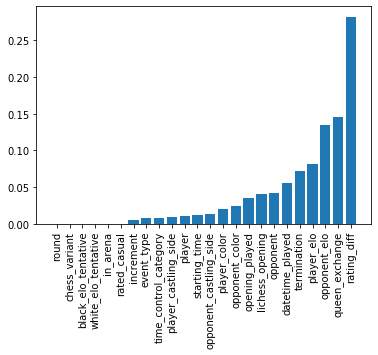

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

feature_importances = [x for x in zip(train_df.drop('player_result', axis=1).columns,
                                      best_rfc.feature_importances_)]
feature_importances.sort(key=lambda x: x[1])
plt.bar(*zip(*feature_importances))
plt.xticks(rotation='vertical')
plt.show()

In [150]:
rcv.best_score_

0.5542032267195018

In [151]:
param_df = pd.DataFrame(rcv.cv_results_)

for col in param_df.columns:
    try:
        param_df[col] = param_df[col].astype(float)
    except:
        pass

In [152]:
param_df.head(3).T

,0,1,2
mean_fit_time,1.00401,0.822128,0.46325
std_fit_time,0.0102907,0.00773165,0.00878154
mean_score_time,0.0288069,0.0197049,0.0143112
std_score_time,0.00744203,0.000781238,0.00313257
param_criterion,gini,entropy,gini
param_max_depth,49,21,26
param_min_samples_leaf,118,278,89
param_min_samples_split,77,46,68
param_n_estimators,113,97,49
params,"{'criterion': 'gini', 'max_depth': 49, 'min_sa...","{'criterion': 'entropy', 'max_depth': 21, 'min...","{'criterion': 'gini', 'max_depth': 26, 'min_sa..."


In [153]:
param_df = param_df[['mean_test_score'] + [x for x in param_df.columns if x.startswith('param_')]]

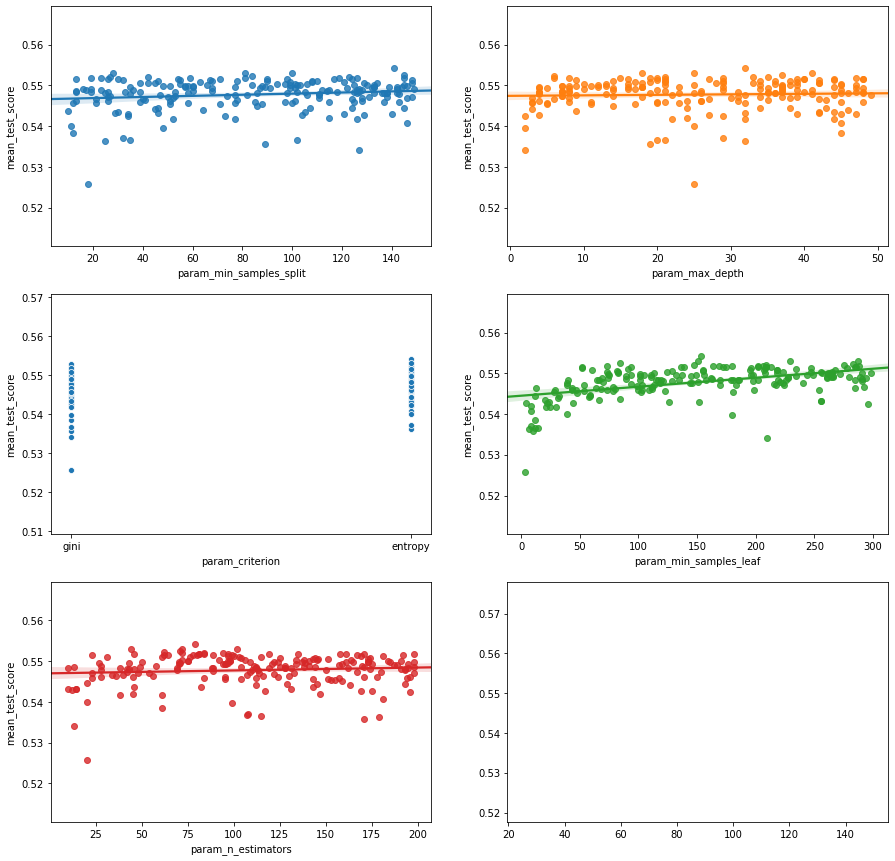

In [154]:
f, axes = plt.subplots(3, 2, figsize=(15, 15))

sns.regplot(x='param_min_samples_split',
             y='mean_test_score',
             #hue='param_max_depth',
             #palette=sns.color_palette('hls', param_df['param_max_depth'].nunique()),
             data=param_df,
             ax=axes[0, 0])

sns.regplot(x='param_max_depth',
             y='mean_test_score',
             data=param_df,
             ax=axes[0, 1])

sns.scatterplot(x='param_criterion',
                y='mean_test_score',
                data=param_df,
                ax=axes[1, 0])

sns.regplot(x='param_min_samples_leaf',
             y='mean_test_score',
             data=param_df,
             ax=axes[1, 1])
sns.regplot(x='param_n_estimators',
             y='mean_test_score',
             data=param_df,
             ax=axes[2, 0])

In [113]:
#best_rfc.score(train_df.drop('player_result', axis=1), train_df['player_result'])